# LIDC

# CNN - VGG16

In [1]:
import os
import pandas as pd
import numpy as np
import time
import random
import cv2

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim


import matplotlib.pyplot as plt

from glob import glob
from PIL import Image

from collections import Counter
from torchvision import models
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Dataset, WeightedRandomSampler
from torchmetrics.classification import MulticlassConfusionMatrix, MulticlassPrecision, MulticlassRecall, MulticlassF1Score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve


## checking if Gpu were recognized

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("PyTorch is using GPU!")
    print(torch.cuda.get_device_name(0)) #prints the name of the GPU.
else:
    device = torch.device("cpu")
    print("PyTorch is using CPU.")

PyTorch is using GPU!
NVIDIA GeForce RTX 3050 Ti Laptop GPU


# Loading Dataset

## Training dataset

In [3]:
path_train = os.path.realpath('data/LIDC_pre/train')

In [4]:
dataset = datasets.ImageFolder(
    root=path_train, 
    transform=transforms.ToTensor()
)
classes = dataset.classes
print(classes)

['cancer', 'non-cancer']


In [5]:
len(dataset)

14421

## Test dataset

In [6]:
path_test = os.path.realpath('data/LIDC_pre/test')

# Validation dataset

In [7]:
path_val = os.path.realpath('data/LIDC_pre/val')

In [8]:
train_dir = path_train
test_dir = path_test
val_dir = path_val

# Preprocessing

In [9]:
IMAGE_SIZE = 227
BATCH_SIZE = 32

### Custom Dataset with Conditional Augmentation

In [10]:
class CancerDataset(Dataset):
    def __init__(self, image_paths, labels, base_transform, minority_transform):
        self.image_paths = image_paths
        self.labels = labels
        self.base_transform = base_transform
        self.minority_transform = minority_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert("RGB")
        
        # Apply stronger augmentation if label is non-cancer (assume 0 = non-cancer, 1 = cancer)
        if label == 0:
            image = self.minority_transform(image)
        else:
            image = self.base_transform(image)

        return image, label

In [11]:
train_dir = path_train
class_map = {'non-cancer': 0, 'cancer': 1}

image_paths = []
labels = []

for class_name in ['non-cancer', 'cancer']:
    folder = os.path.join(train_dir, class_name)
    for img_path in glob(os.path.join(folder, '*')):
        image_paths.append(img_path)
        labels.append(class_map[class_name])

### Shuffle before create dataset

In [12]:
combined = list(zip(image_paths, labels))
random.shuffle(combined)
image_paths, labels = zip(*combined)

In [13]:
base_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    # transforms.Normalize([0.5] * 3, [0.5] * 3),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

minority_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(10),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    # transforms.Normalize([0.5] * 3, [0.5] * 3),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define data augmentation for the training dataset
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    # transforms.RandomResizedCrop(IMAGE_SIZE),   # Random crop and resize
    # transforms.RandomHorizontalFlip(p=0.5),     # Random horizontal flip
    # transforms.RandomRotation(20),              # Random rotation within ±20 degrees
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # *******
    # transforms.RandomAffine(degrees=0, shear=10, scale=(0.8, 1.2)),  # Shearing
    transforms.ToTensor(),                      # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize
])

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define validation dataset - no augmentation, only resizing and normalization
test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# split train_dataset and load
train_dataset = CancerDataset(image_paths=image_paths,labels=labels,base_transform=base_transform,minority_transform=minority_transform)
# train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(root=val_dir, transform=val_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=test_transforms)

# Create the Weighted Sampler and DataLoader
# Compute class weights (0 = non-cancer, 1 = cancer)
class_counts = [labels.count(0), labels.count(1)]
weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [weights[label] for label in labels]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Define loaders

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


print(f'Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}')

Training samples: 14421, Validation samples: 4405, Test samples: 5052


In [14]:
# Collect all labels from the train_dataset
labels = [label for _, label in train_dataset]

# Count label occurrences
label_counts = Counter(labels)

# Manually map index to class name based on your dataset definition
# For example, if 0 = 'cancer' and 1 = 'non-cancer', update accordingly:
index_to_class = {0: 'non-cancer', 1: 'cancer'}  # Adjust if your label encoding is different

# Print results
print("\nTraining set counts:")
for idx, count in label_counts.items():
    print(f"Class: {index_to_class[idx]}, Count: {count}")


Training set counts:
Class: non-cancer, Count: 5375
Class: cancer, Count: 9046


# Architecture

In [15]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2

model = models.vgg16(weights=None) 
model.classifier[6] = nn.Linear(4096, num_classes)
model = model.to(device)

print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [32, 2]                   --
├─Sequential: 1-1                        [32, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 64, 227, 227]        1,792
│    └─ReLU: 2-2                         [32, 64, 227, 227]        --
│    └─Conv2d: 2-3                       [32, 64, 227, 227]        36,928
│    └─ReLU: 2-4                         [32, 64, 227, 227]        --
│    └─MaxPool2d: 2-5                    [32, 64, 113, 113]        --
│    └─Conv2d: 2-6                       [32, 128, 113, 113]       73,856
│    └─ReLU: 2-7                         [32, 128, 113, 113]       --
│    └─Conv2d: 2-8                       [32, 128, 113, 113]       147,584
│    └─ReLU: 2-9                         [32, 128, 113, 113]       --
│    └─MaxPool2d: 2-10                   [32, 128, 56, 56]         --
│    └─Conv2d: 2-11                      [32, 256, 56, 56]         29

# Trainning

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience=3):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Metrics
    confusion_matrix = MulticlassConfusionMatrix(num_classes=2)
    precision = MulticlassPrecision(num_classes=10, average='macro')
    recall = MulticlassRecall(num_classes=10, average='macro')
    f1_score = MulticlassF1Score(num_classes=10, average='macro')

    # Early stopping parameters
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_path = '/home/vivianea/projects/BrainInnov/models/best_model_vgg16.pth' # Path to save the best model

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # feed foward
            outputs = model(inputs)
            
            # Compute loss using cross entropy
            loss = criterion(outputs, labels)

            # backpropagation
            loss.backward()

            # Update weights
            optimizer.step()

            # Update results
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluation part to print metrics for each epoch
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()

                # For metrics
                all_preds.append(preds.cpu())
                all_labels.append(labels.cpu())

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct_val / total_val)

        
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)

        
        precision_value = precision(all_preds, all_labels)
        recall_value = recall(all_preds, all_labels)
        f1_value = f1_score(all_preds, all_labels)
        conf_matrix = confusion_matrix(all_preds, all_labels)

        
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.2f}%")
        print(f"Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]:.2f}%")
        print(f"Precision: {precision_value:.4f} | Recall: {recall_value:.4f} | F1 Score: {f1_value:.4f}\n")
        
        # --- Early Stopping Logic ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0 # Reset patience counter
            # Save the best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'confusion_matrix': conf_matrix.cpu().numpy() # Save the confusion matrix of the best model
                }, best_model_path)
            print(f"Validation loss improved. Saving best model to {best_model_path}")
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs due to no improvement in validation loss for {patience} consecutive epochs.")
            break # Exit the training loop

    print("\nTraining complete.")
    # Load the best model after training is complete (either by early stopping or max epochs)
    print(f"Loading best model from {best_model_path} for final metrics.")
    checkpoint = torch.load(best_model_path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    # You might not need to load optimizer state if you're just doing inference or final evaluation
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    final_conf_matrix = checkpoint['confusion_matrix'] # Retrieve the confusion matrix of the best model

    return train_losses, val_losses, train_accuracies, val_accuracies, conf_matrix

In [18]:
t1 = time.time()
print(f"Using device: {device}")
train_losses, val_losses, train_accuracies, val_accuracies, conf_matrix = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=50)

print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Using device: cuda
Epoch 1/50
Train Loss: 0.6854 | Train Acc: 54.16%
Val Loss: 0.6939 | Val Acc: 40.41%
Precision: 0.2020 | Recall: 0.5000 | F1 Score: 0.2878

Validation loss improved. Saving best model to /home/vivianea/projects/BrainInnov/models/best_model_AlexNet.pth
Epoch 2/50
Train Loss: 0.6935 | Train Acc: 50.13%
Val Loss: 0.6986 | Val Acc: 40.41%
Precision: 0.2020 | Recall: 0.5000 | F1 Score: 0.2878

Validation loss did not improve. Patience: 1/3
Epoch 3/50
Train Loss: 0.6934 | Train Acc: 50.35%
Val Loss: 0.6909 | Val Acc: 59.59%
Precision: 0.2980 | Recall: 0.5000 | F1 Score: 0.3734

Validation loss improved. Saving best model to /home/vivianea/projects/BrainInnov/models/best_model_AlexNet.pth
Epoch 4/50
Train Loss: 0.6937 | Train Acc: 50.22%
Val Loss: 0.6876 | Val Acc: 59.59%
Precision: 0.2980 | Recall: 0.5000 | F1 Score: 0.3734

Validation loss improved. Saving best model to /home/vivianea/projects/BrainInnov/models/best_model_AlexNet.pth
Epoch 5/50
Train Loss: 0.6939 | Train 

# Evaluating

In [19]:
model.eval() 

with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Test Accuracy of the model on the {total} test images: {(correct / total) * 100:.2f}%')

Test Accuracy of the model on the 5052 test images: 64.51%


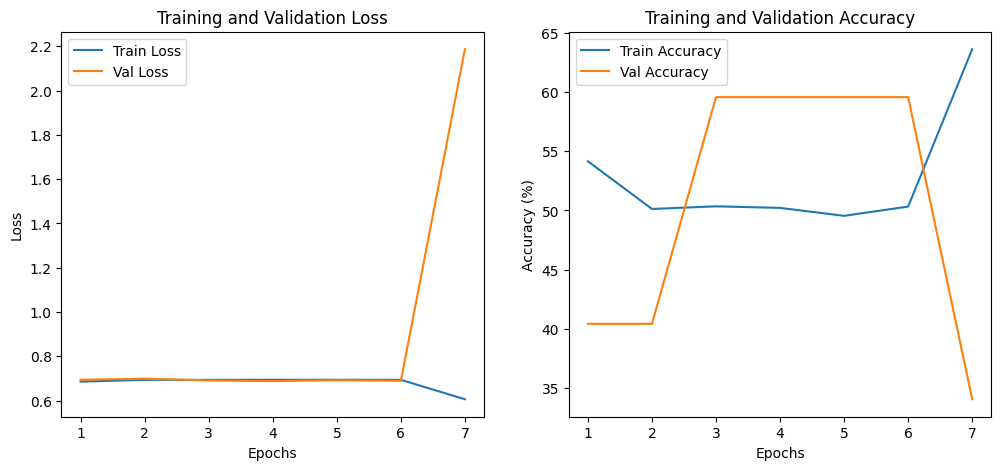

In [20]:
def plot_training(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

plot_training(train_losses, val_losses, train_accuracies, val_accuracies)

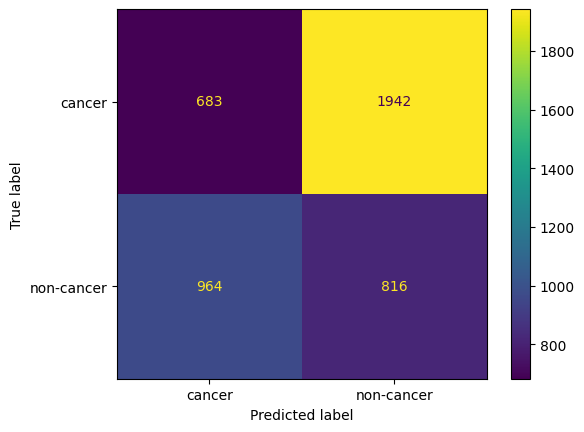

In [21]:
cm = conf_matrix.cpu().numpy()
disp = ConfusionMatrixDisplay(cm, display_labels=classes,)
disp.plot()

# Metrics

In [22]:
precision = MulticlassPrecision(num_classes=num_classes, average=None)
recall = MulticlassRecall(num_classes=num_classes, average=None)
f1_score = MulticlassF1Score(num_classes=num_classes, average=None)


all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())


all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)


per_class_precision = precision(all_preds, all_labels)
per_class_recall = recall(all_preds, all_labels)
per_class_f1 = f1_score(all_preds, all_labels)


for i, name in enumerate(classes):
    print(f"Class {i}-{name}: Precision: {per_class_precision[i]:.2f}, Recall: {per_class_recall[i]:.2f}, F1-Score: {per_class_f1[i]:.2f}")

Class 0-cancer: Precision: 0.60, Recall: 1.00, F1-Score: 0.75
Class 1-non-cancer: Precision: 0.00, Recall: 0.00, F1-Score: 0.00


In [23]:
y_true = []
y_probs = []  # Collect probabilities for class 1 (cancer)

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:  # or test_loader
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)  # raw logits or softmax
        probs = torch.softmax(outputs, dim=1)[:, 1]  # class 1 = cancer

        y_true.extend(labels.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

AUC: 0.3459


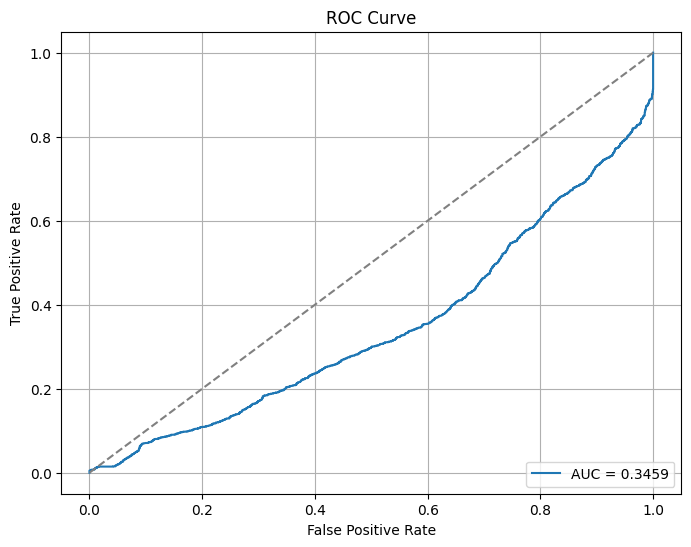

In [24]:
# Compute AUC
auc = roc_auc_score(y_true, y_probs)
print(f"AUC: {auc:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Save Model

In [ ]:
torch.save(model.state_dict(), '/home/vivianea/projects/BrainInnov/models/model_vgg16.pt')

# GradCam

In [26]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = []
        self.activations = []

        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations.append(output)

        def backward_hook(module, grad_in, grad_out):
            self.gradients.append(grad_out[0])

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, target_class=None):
        self.model.eval()
        self.gradients = []
        self.activations = []

        input_tensor = input_tensor.unsqueeze(0) if input_tensor.dim() == 3 else input_tensor
        input_tensor = input_tensor.to(next(self.model.parameters()).device)

        # Forward pass
        output = self.model(input_tensor)
        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Backward pass
        self.model.zero_grad()
        class_score = output[0, target_class]
        class_score.backward()

        # Get the gradients and activations
        gradients = self.gradients[0].cpu().data.numpy()[0]
        activations = self.activations[0].cpu().data.numpy()[0]

        # Compute weights
        weights = np.mean(gradients, axis=(1, 2))

        # Compute CAM
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)
        cam -= cam.min()
        cam /= cam.max() if cam.max() != 0 else 1
        cam = cv2.resize(cam, (input_tensor.shape[2], input_tensor.shape[3]))

        return cam, target_class

    def visualize(self, input_tensor, cam, unnormalize=True):
        img = input_tensor.cpu().squeeze().permute(1, 2, 0).numpy()
        if unnormalize:
            img = (img * 0.5) + 0.5  # if you used Normalize(mean=0.5, std=0.5)

        img = np.clip(img, 0, 1)
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        overlay = heatmap + img
        overlay = overlay / np.max(overlay)

        # Plotting
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Original")
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Grad-CAM")
        plt.imshow(cam, cmap='jet')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Overlay")
        plt.imshow(overlay)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

/home/vivianea/apps/miniconda3/envs/lidc_env/lib/python3.12/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


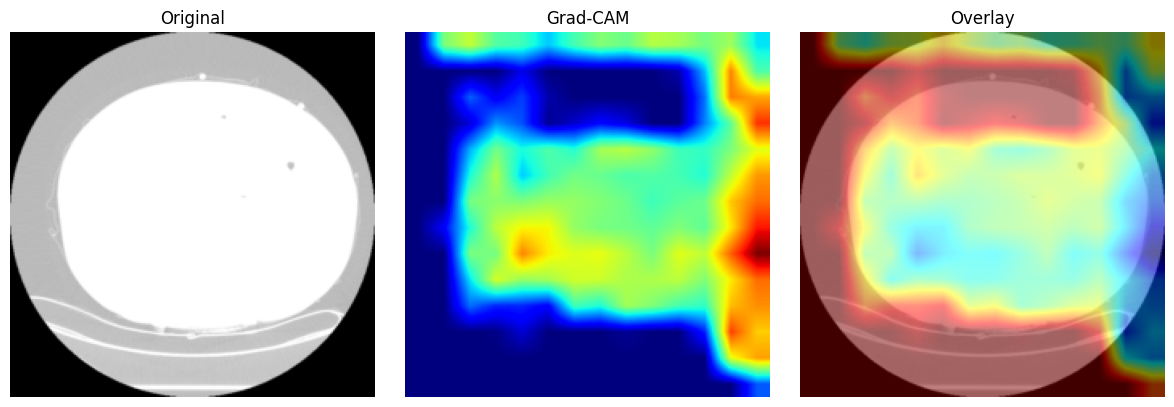

In [27]:
# Choose target layer (last conv in VGG-16)
target_layer = model.features[28]

# Initialize GradCAM
grad_cam = GradCAM(model, target_layer)

# Run on one sample
image, label = test_dataset[0]  # image should be a tensor
cam, predicted_class = grad_cam.generate(image)

# Show visualization
grad_cam.visualize(image, cam)